In [1]:

from sae_lens import HookedSAETransformer, SAE, SAEConfig
from gemma_utils import get_gemma_2_config, gemma_2_sae_loader

In [67]:

import numpy as np
import torch
import tqdm
import einops
import re
from jaxtyping import Int, Float
from typing import List, Optional, Any
from torch import Tensor
import json
import os
from torch.utils.data import Dataset, DataLoader
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from transformer_lens.utils import get_act_name
from IPython.display import display, HTML

In [3]:

np.random.seed(0)
random.seed(0)
torch.random.manual_seed(0)

In [4]:

model = HookedSAETransformer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [91]:
text = """<body><h1>List of My Brother's Favourite Cities</h1><ul><li>"""
tokens = model.to_tokens(text)
out = model.generate(
    tokens,
    max_new_tokens = 100,
    temperature = 0.7,
    top_p = 0.9,
    stop_at_eos=True,
    )

visualize_html(model.to_string(out[-1]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
def visualize_html(text):
    text = text.replace("<eos>","")
    text = text.replace("<bos>","")
    display(HTML(text))
    

In [94]:
string = "<bos><body><h1>List of My Brother's Favourite Cities</h1><ul><li>Bangkok, Thailand</li><li>London, England</li><li>Paris, France</li><li>Melbourne, Australia</li><li>Toronto, Canada</li><li>New York, USA</li></ul></body>\n<eos>"
tokens = model.to_tokens(string, prepend_bos=False)

At this point and with the changes that we have made to the setup to reliably produce list that don't spiral out of control, we ask ourselves how can the model decide to add another elemnt or not.


Taking into account the moel's tokenization:

- `'<ul>' '<', 'ul', '>'`
- `'><li>' '><', 'li', '>'`
- `'</li>' '</', 'li', '>'`
- `'><ul>' '></', 'ul', '>'`

The model will continue the list while remaining html consistent if it uses the token `><` instead of the token `></`

In [148]:
tok_id = model.to_tokens("></", prepend_bos=False)[0]

tok_id2 = model.to_tokens("><", prepend_bos=False)[0]
tok_pos = torch.where(out[0] == tok_id)[0][0].tolist()
all_tok2_pos = torch.where(out[0] == tok_id2)[0][1:].tolist()

In [121]:
with torch.no_grad():
    logits = model(tokens)

In [185]:
for elem in all_tok2_pos + [tok_pos]:
    l = logits[0,elem-1]
    print(l[tok_id]-l[tok_id2])
    #print([model.to_str_tokens(i) for i in l.topk(10).indices])

tensor([-2.0125], device='cuda:0')
tensor([-2.1449], device='cuda:0')
tensor([-0.7575], device='cuda:0')
tensor([-0.6126], device='cuda:0')
tensor([-0.0059], device='cuda:0')
tensor([0.2700], device='cuda:0')


## Logit Lens

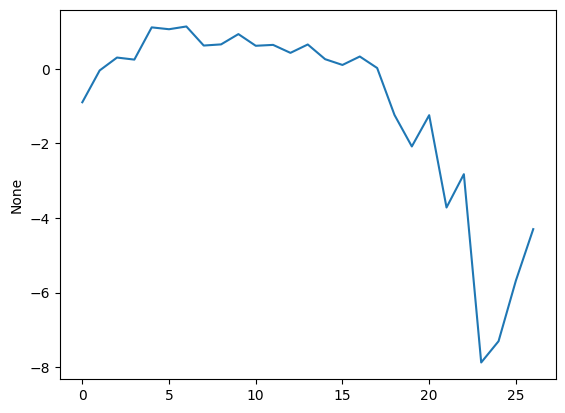

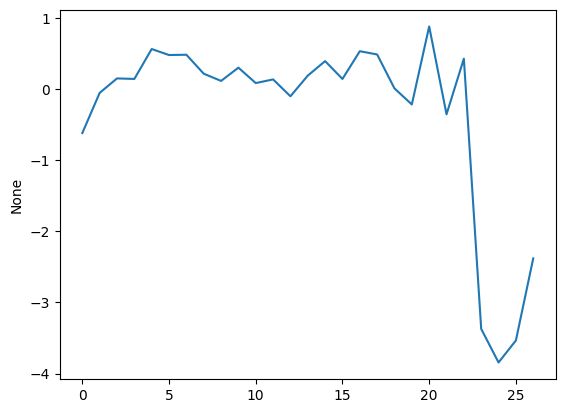

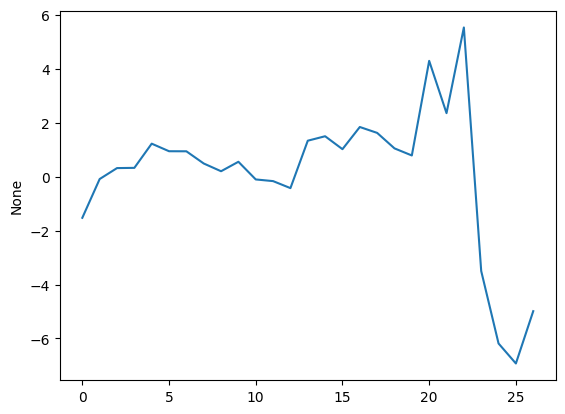

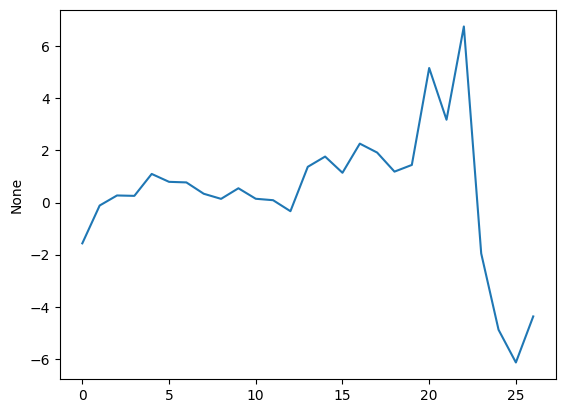

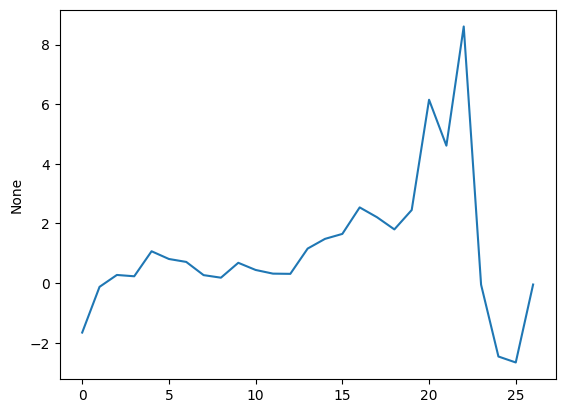

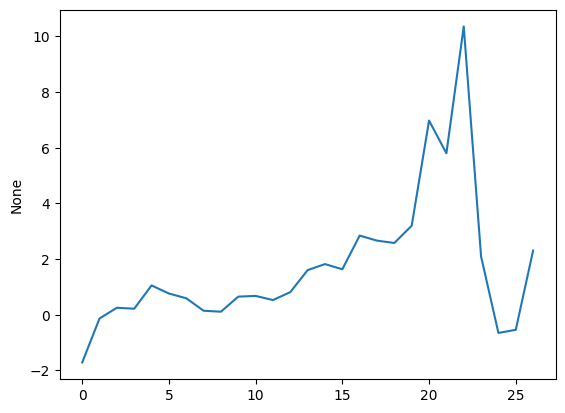

In [188]:
pattern_hook_names_filter = lambda name: name.endswith("hook_resid_pre") or name.endswith("25.hook_resid_post") or  name.endswith('ln_final.hook_scale'

)

with torch.no_grad():
    _,cache = model.run_with_cache(tokens,names_filter = pattern_hook_names_filter)


for elem in all_tok2_pos + [tok_pos]:
    accumulated_residual, labels = cache.accumulated_resid(
        incl_mid=False, pos_slice=elem-1, return_labels=True,apply_ln = True
    )

    dir = model.W_U[:,tok_id].detach()-model.W_U[:,tok_id2].detach()
    logit_lens = einops.einsum(dir[:,0], accumulated_residual,"d_model,comps batch d_model -> comps batch ")

    sns.lineplot(x = list(range(logit_lens.shape[0])), y = logit_lens[:,0].cpu())
    plt.show()


**Clearly something is happening from layer 22 to layer 23**


Next thing to do is to perform feature attribution in layer 22 and layer 23 and check which feature is more related to the logit difference.

Then after that we weill perform some ablations

In [195]:
from attribution_utils import calculate_feature_attribution
from torch.nn.functional import log_softmax
from gemma_utils import get_all_string_min_l0_resid_gemma

In [201]:

def metric_fn(logits: torch.Tensor, pos:int=tok_pos) -> torch.Tensor:
    return logits[0,pos,3119] - logits[0,pos,2577]

In [197]:
full_strings = get_all_string_min_l0_resid_gemma()
layer = 22
saes_dict = {}
with torch.no_grad():
    repo_id = "google/gemma-scope-2b-pt-res"
    folder_name = full_strings[layer]
    config = get_gemma_2_config(repo_id, folder_name)
    cfg, state_dict, log_spar = gemma_2_sae_loader(repo_id, folder_name)
    sae_cfg = SAEConfig.from_dict(cfg)
    sae = SAE(sae_cfg)
    sae.load_state_dict(state_dict)
    sae.to("cuda:0")

    saes_dict[sae.cfg.hook_name] = sae

/root/GemmaExploration/gemma_utils.py:158: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid_dict = df[df['release'] == "gemma-scope-2b-pt-res"]['saes_map'][0]


In [202]:

feature_attribution_df = calculate_feature_attribution(
    model = model,
    input = tokens,
    metric_fn = metric_fn,
    include_saes=saes_dict,
    include_error_term=True,
    return_logits=True,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 59.50 MiB is free. Process 1669649 has 23.62 GiB memory in use. Of the allocated memory 23.06 GiB is allocated by PyTorch, and 255.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)